# Architecture of this code

This code is structured as follows:

#### Loading the Data

Input the path to your files in the section "Input Filenames"

Each column of the input files is read in as a numpy array. Each numpy array is then stored within the ```data_trace```, ```data_condtens```, and ```data_halltens``` objects. These objects are python ```dict``` objects, and the key assigned to each column is created in ```colnames```. 

For example, the column in case.trace which corresponds to temperature is stored as ```data_trace['T']``` . The column in case.condens which corresponds to the $xx$ component of the Seebeck coefficient tensor, $S_{xx}$, is stored as ```data_condtens['S_xx']```.


#### Filtering the data

Sometimes you do not want to plot every value in a column of case.trace. 

Suppose we have calculated the Seebeck coefficient $S$ against the chemical potential $\mu$ for a range of temperatures, all of which are stored in ```case.trace```. Suppose now we only want to plot for $T = 300$K.

We simply make a condition:   ```cond = np.isclose(data_trace['T'] , 300)```
```cond``` is a list of all the indexs for which the temperature is 300. 

Now we can plot:
```pl.plot( data_trace['mu'][cond] , data_trace['S'][cond]``` ) , only plotting the data for which ```data_trace['T'] = 300```

Multiple conditions/filters can be combined using ```combine_conditions```

#### Plotting the data

Once loading, plot the data as you choose, e.g. 

```pl.plot( data_trace['T'], data_trace['sigma'] )``` will plot the column in ```case.trace``` corresponding to the reduced electrical conductivity $\sigma/\tau$ against the column in ```case.trace``` which corresponds to temperature $T$.

### Import things

In [1]:
import numpy as np
import matplotlib.pylab as pl

eVtoRy = 0.0734986176
eVtoHa = 0.0734986176 / 2
RytoeV = 1/eVtoRy
HatoeV = 1/eVtoHa

### Make the colnames

This makes keywords for each column in the .trace, .condtens, and .halltens files. 

In [2]:
colnames_trace=[ 'mu', 'T' , 'N', 'sdos' , 'S' , 'sigma' , 'Rh' , 'kappa0' , 'cv_el' , 'chi' ]

signames=[]
Snames=[]
kapnames=[]
Rhnames=[]
for j in ['x','y','z']:
    for i in ['x','y','z']:
        signames.append( 'sigma_'+i+j )
        Snames.append( 'S_'+i+j )
        kapnames.append( 'kappa0_'+i+j )
for k in ['x','y','z']:
    for j in ['x','y','z']:
        for i in ['x','y','z']:
            Rhnames.append( 'Rh_'+i+j+k )

colnames_condtens= ['mu' , 'T', 'N' ] + signames + Snames + kapnames
colnames_halltens=['mu', 'T', 'N', ] + Rhnames

#colnames = colnames_scf + colnames_conc + colnames_condtens + colnames_halltens + colnames_trace

### Load_Data Function

Data is loaded from the .trace file etc. and saved as a dict object, where each key is a column name, and each value is a numpy array corresponding to that column.

In [48]:
def load_data( phile , colnames ):
    
    # Find the number of columns. Takes the first line that isn't a comment. 
    with open(phile) as f:
        j=f.readline()
        if j[0] == '#':
            j=f.readline()
        ncols=len(j.split())
    
    # Check that the length of colnames agrees with the output data
    if len(colnames) != ncols:
        print("ERROR:  len(colnames) != ncols. The names are not commensurate. Is there a different number of columns?")
        print('len(colnames) = ',len(colnames))
        print('ncols = ',ncols)
        return
    
    # Load the file
    d=np.loadtxt( phile , usecols=range(0,ncols) ).T
    
    # Creat a dictionary object, there a 'key' represents each column name
    data={}
    for col, name in enumerate(colnames):
        data[name] = d[col]
    return data


def merge_datas(list_of_datas):
    data_master = list_of_datas[0].copy()
    if len(list_of_datas) > 1:
        for d in list_of_datas[1:]:
            data_master.update(d)
    return data_master

# Input filenames

loads the data from the .trace, .condtens, and .halltens files. Combines them. 

Write the path to your case.trace, case.condtens, and case.halltens files here

In [1]:
data_trace = load_data('$PATH_TO/case.trace', colnames_trace)
data_condtens = load_data('$PATH_TO/case.condtens', colnames_condtens)
data_halltens = load_data('$PATH_TO/case.halltens', colnames_halltens)

data = merge_datas([data_trace, data_condtens, data_halltens])

data.keys()

NameError: name 'load_data' is not defined

### Method to filter the data
combine_conditions is designed so that a set of multliple conditions can be made on the dataset, such as only plotting a specific temperature, or only plotting cases which are $n$-doped. This combines rows with specified attributes to make an array of indexs for plotting. 

In [50]:
def combine_conditions(condlist):
    where_all_true=condlist[0]
    for condition in condlist[1:]:
        where_all_true=np.logical_and(where_all_true , condition)
    return where_all_true

For example --- to plot all data at T=300 and N<0, simply

1) make two conditions:

In [56]:
cond1 = np.isclose(data_trace['T'] , 300)
cond2 = np.where(data_trace['N'] > 0.00001 , True, False)

2) combine the conditions to make desired indices array:

In [57]:
conds = combine_conditions([cond1 , cond2])

### Now ready to plot

In [58]:
x = data_trace['N'][conds]

y = data_trace['sigma'][conds]  

argy=np.argsort(x)

x[argy]

array([2.24880e-05, 3.85508e-05, 5.46136e-05, 6.42513e-05, 6.42513e-04,
       2.24880e-03, 3.85508e-03, 5.46136e-03, 6.42513e-03])

(Text(0.5, 0, 'N (e/uc)'), Text(0, 0.5, '$\\sigma/\\tau$ (1/$\\Omega$ms)'))

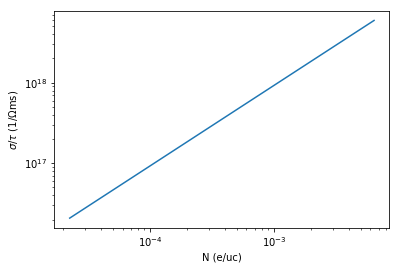

In [66]:
fig = pl.figure()

pl.plot(x[argy] , y[argy])

pl.xscale('log') , pl.yscale('log')
pl.xlabel('N (e/uc)') , pl.ylabel('$\sigma/\\tau$ (1/$\Omega$ms)')

### Save the current figure

In [ ]:
fig.savefig('$PATH_TO/figure.pdf')